In [ ]:
import torch
import torch.nn as nn


class Encoder(nn.Module):
  def __init__(self, in_channel=256, latent_dim=64):
    super(Encoder, self).__init__()

    self.in_channel = in_channel
    self.latent_dim = latent_dim
    self.hidden_dim = self.calHidDim(in_channel, latent_dim)
    print('Encoder Hidden: ', self.hidden_dim)

    self.myEncoder = nn.ModuleList([nn.Linear(self.hidden_dim[i], self.hidden_dim[i+1]) for i in range(len(self.hidden_dim)-1)])
    self.relu = nn.ReLU()

  
  def calHidDim(self, start, end):
    #hidden_dim = [784]
    hidden_dim = [784, 256, 128]
    '''
    while(True):
      hidden_dim.append(start)
      if(start==end):
        break
      start=start//2
    '''
    hidden_dim.append(end)

    return hidden_dim

  def forward(self, x):
    for i, func in enumerate(self.myEncoder):
      x = self.relu(func(x))

    return x


class Decoder(nn.Module):
  def __init__(self, in_channel=256, latent_dim=64):
    super(Decoder, self).__init__()

    self.in_channel = in_channel
    self.latent_dim = latent_dim
    self.hidden_dim = self.calHidDim(latent_dim, in_channel)
    self.hidden_dim.append(784)
    print('Decoder Hidden: ', self.hidden_dim)
 
    self.myDecoder = nn.ModuleList([nn.Linear(self.hidden_dim[i], self.hidden_dim[i+1]) for i in range(len(self.hidden_dim)-1)])
    self.relu = nn.ReLU()

  
  def calHidDim(self, start, end):
    #hidden_dim = []
    hidden_dim = [start, 128, 256]
    '''
    while(True):
      hidden_dim.append(start)
      if(start==end):
        break
      start=start*2
    '''

    return hidden_dim

  def forward(self, x):
    for i, func in enumerate(self.myDecoder):
      x = self.relu(func(x))

    return x


class AutoEncoder(nn.Module):
  def __init__(self, in_channel, latent_dim=64):
    super(AutoEncoder, self).__init__()

    self.in_channel = in_channel
    self.latent_dim = latent_dim

    # Encoder + Decoder
    self.encoder = Encoder(in_channel, latent_dim)
    self.decoder = Decoder(in_channel, latent_dim)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x


enc = Encoder()
dec = Decoder()
print(enc)
print(dec)

Encoder Hidden:  [784, 256, 128, 64]
Decoder Hidden:  [64, 128, 256, 784]
Encoder(
  (myEncoder): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (relu): ReLU()
)
Decoder(
  (myDecoder): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
  (relu): ReLU()
)


In [ ]:
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class Network():
  def __init__(self, latent_dims=64, num_epochs=50, batch_size=64, learning_rate=1.0e-3, gpu=True):
    self.latent_dims = latent_dims
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.in_channel = 256 # 784 -> 256 -> 128 -> 64 ...
    self.learning_rate = learning_rate
    self.gpu = gpu

    self._init_dataset()
    self._init_model()

  def _init_dataset(self):

    train_data = MNIST(root='./dataset', download=True, train=True, transform=transforms.ToTensor())
    test_data = MNIST(root='./dataset', download=True, train=False, transform=transforms.ToTensor())

    train_data2 = FashionMNIST(root='./dataset', download=True, train=True, transform=transforms.ToTensor())
    test_data2 = FashionMNIST(root='./dataset', download=True, train=False, transform=transforms.ToTensor())

    self.train_queue = data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
    self.test_queue = data.DataLoader(test_data, batch_size=self.batch_size, shuffle=True)

    self.train_queue2 = data.DataLoader(train_data2, batch_size=self.batch_size, shuffle=True)
    self.test_queue2 = data.DataLoader(test_data2, batch_size=self.batch_size, shuffle=True)

  def _init_model(self):
    self.device = torch.device('cuda' if (torch.cuda.is_available() & self.gpu) else 'cpu')

    model = AutoEncoder(self.in_channel, self.latent_dims)
    self.model = model.to(self.device)

    self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)

  def show_images(self, images, num_images=16):
    #sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtn = int(np.ceil(np.sqrt(num_images)))

    for index, image in enumerate(images):
      if index < num_images:
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')
        

  def train(self):
    train_loss = []
    train_loss_l1 = []

    self.model.train()
    for epoch in range(self.num_epochs):
      loss_sum = 0
      loss_sum_l1 = 0
      show_inputs = None
      show_outputs = None
      for step, (inputs, _) in enumerate(self.train_queue):
        self.optimizer.zero_grad()

        inputs = inputs.view(-1, 784).to(self.device)
        outputs = self.model(inputs)

        loss = F.mse_loss(outputs, inputs)
        l1_loss = F.l1_loss(outputs, inputs)

        loss_sum += loss.item()
        loss_sum_l1 += l1_loss.item()
        train_loss.append(loss.item())
        train_loss_l1.append(l1_loss.item())

        loss.backward()
        self.optimizer.step()
        show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()
      
      train_avg_loss = loss_sum/step
      train_avg_loss_l1 = loss_sum_l1/step
      print('Epoch [{}]/[{}], MSE:{}, L1 Error:'.format(epoch, self.num_epochs, train_avg_loss), train_avg_loss_l1)

      if epoch == self.num_epochs-1:
        self.show_images(show_inputs)
        plt.savefig('inputs_'+str(self.latent_dims)+'.png')
        plt.show()
        self.show_images(show_outputs)
        plt.savefig('outputs_'+str(self.latent_dims)+'.png')
        plt.show()

    plt.subplot(211)
    plt.plot(train_loss)

    plt.subplot(212)
    plt.plot(train_loss_l1)

    torch.save(self.model, './autoencoder'+str(self.latent_dims)+'.pth')

  def val(self):
    test_loss = []

    self.model = torch.load('autoencoder'+str(self.latent_dims)+'.pth')
    self.model.eval()
    loss_sum = 0
    loss_sum_l1 = 0

    show_inputs = None
    show_outputs = None
    with torch.no_grad():
      for step, (inputs, _) in enumerate(self.test_queue):

        inputs = inputs.view(-1, 784).to(self.device)
        #self.show_images(inputs.cpu())
        #plt.show()
        outputs = self.model(inputs)
        #self.show_images(outputs.cpu())
        #plt.show()
        show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

        loss = F.mse_loss(outputs, inputs)
        l1_loss = F.l1_loss(outputs, inputs)
        loss_sum += loss.item()
        loss_sum_l1 += l1_loss.item()


    self.show_images(show_inputs)
    plt.savefig('inputs_'+str(self.latent_dims)+'_val.png')
    plt.show()
    self.show_images(show_outputs)
    plt.savefig('outputs_'+str(self.latent_dims)+'_val.png')
    plt.show()

    test_avg_loss = loss_sum/step
    train_avg_loss_l1 = loss_sum_l1/step
    print('MSE:{}, L1 error:{}'.format(test_avg_loss, train_avg_loss_l1))





  def train_fashion(self):
    train_loss = []
    train_loss_l1 = []

    self.model.train()
    for epoch in range(self.num_epochs):
      loss_sum = 0
      loss_sum_l1 = 0
      show_inputs = None
      show_outputs = None
      for step, (inputs, _) in enumerate(self.train_queue2):
        self.optimizer.zero_grad()

        inputs = inputs.view(-1, 784).to(self.device)
        outputs = self.model(inputs)

        loss = F.mse_loss(outputs, inputs)
        l1_loss = F.l1_loss(outputs, inputs)

        loss_sum += loss.item()
        loss_sum_l1 += l1_loss.item()
        train_loss.append(loss.item())
        train_loss_l1.append(l1_loss.item())

        loss.backward()
        self.optimizer.step()
        show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()
      
      train_avg_loss = loss_sum/step
      train_avg_loss_l1 = loss_sum_l1/step
      print('Epoch [{}]/[{}], MSE:{}, L1 Error:'.format(epoch, self.num_epochs, train_avg_loss), train_avg_loss_l1)

      if epoch == self.num_epochs-1:
        self.show_images(show_inputs)
        plt.savefig('inputs_fashion_'+str(self.latent_dims)+'.png')
        plt.show()
        self.show_images(show_outputs)
        plt.savefig('outputs_fashion_'+str(self.latent_dims)+'.png')
        plt.show()

    plt.subplot(211)
    plt.plot(train_loss)

    plt.subplot(212)
    plt.plot(train_loss_l1)

    torch.save(self.model, './autoencoder_fashion'+str(self.latent_dims)+'.pth')

  def val_fashion(self):
    test_loss = []

    self.model = torch.load('autoencoder_fashion'+str(self.latent_dims)+'.pth')
    self.model.eval()
    loss_sum = 0
    loss_sum_l1 = 0

    show_inputs = None
    show_outputs = None
    with torch.no_grad():
      for step, (inputs, _) in enumerate(self.test_queue2):

        inputs = inputs.view(-1, 784).to(self.device)
        #self.show_images(inputs.cpu())
        #plt.show()
        outputs = self.model(inputs)
        #self.show_images(outputs.cpu())
        #plt.show()
        show_inputs, show_outputs = inputs.detach().cpu().numpy(), outputs.detach().cpu().numpy()

        loss = F.mse_loss(outputs, inputs)
        l1_loss = F.l1_loss(outputs, inputs)
        loss_sum += loss.item()
        loss_sum_l1 += l1_loss.item()


    self.show_images(show_inputs)
    plt.savefig('inputs_fashion_'+str(self.latent_dims)+'_val.png')
    plt.show()
    self.show_images(show_outputs)
    plt.savefig('outputs_fashion_'+str(self.latent_dims)+'_val.png')
    plt.show()

    test_avg_loss = loss_sum/step
    train_avg_loss_l1 = loss_sum_l1/step
    print('MSE:{}, L1 error:{}'.format(test_avg_loss, train_avg_loss_l1))




In [ ]:
# Training latent dimension = 64 
if __name__ == '__main__':
    train_network = Network()
    train_network.train()
    train_network.val()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw

Encoder Hidden:  [784, 256, 128, 64]
Decoder Hidden:  [64, 128, 256, 784]
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 7

KeyboardInterrupt: ignored

Encoder Hidden:  [784, 256, 128, 32]
Decoder Hidden:  [32, 128, 256, 784]
Epoch [0]/[50], MSE:0.033307030192688665, L1 Error: 0.07813570377682291
Epoch [1]/[50], MSE:0.019672281600797318, L1 Error: 0.05499697437265385
Epoch [2]/[50], MSE:0.016460366390065043, L1 Error: 0.048747771438469624
Epoch [3]/[50], MSE:0.015005875506071551, L1 Error: 0.045739361183397796
Epoch [4]/[50], MSE:0.014227129209870145, L1 Error: 0.04410286894189383
Epoch [5]/[50], MSE:0.01374534295281453, L1 Error: 0.04308290277054114
Epoch [6]/[50], MSE:0.013349605674518466, L1 Error: 0.042261048376146734
Epoch [7]/[50], MSE:0.013029456356283886, L1 Error: 0.041595759524257106
Epoch [8]/[50], MSE:0.012647533304233943, L1 Error: 0.04083304288483989
Epoch [9]/[50], MSE:0.012380729039798997, L1 Error: 0.04027577158830972
Epoch [10]/[50], MSE:0.012166286131870022, L1 Error: 0.039803488412623475
Epoch [11]/[50], MSE:0.012003981819418095, L1 Error: 0.039441178514042684
Epoch [12]/[50], MSE:0.011884102695238883, L1 Error: 0.

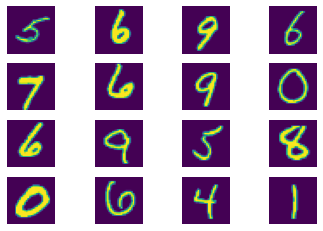

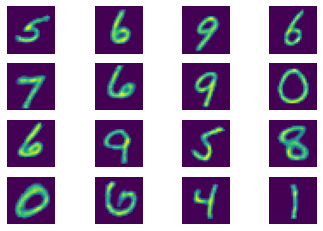

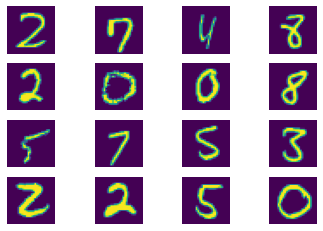

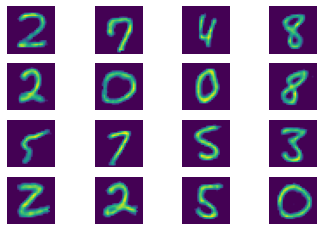

MSE:0.01045098041709608, L1 error:0.0363227849205335


In [ ]:
# Training latent dimension = 32 
if __name__ == '__main__':
    train_network = Network(latent_dims=32)
    train_network.train()
    train_network.val()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Encoder Hidden:  [784, 256, 128, 4]
Decoder Hidden:  [4, 128, 256, 784]
Epoch [0]/[50], MSE:0.04870478180709236, L1 Error: 0.10571854925747233
Epoch [1]/[50], MSE:0.039495980384955415, L1 Error: 0.09035822330887569
Epoch [2]/[50], MSE:0.0375843452987447, L1 Error: 0.0867929394767404
Epoch [3]/[50], MSE:0.036590781239762886, L1 Error: 0.08491686985230625
Epoch [4]/[50], MSE:0.035890982542962246, L1 Error: 0.08359002007078081
Epoch [5]/[50], MSE:0.035370796199255844, L1 Error: 0.08267893258923527
Epoch [6]/[50], MSE:0.03496502072867424, L1 Error: 0.08198507259755913
Epoch [7]/[50], MSE:0.034011095372627996, L1 Error: 0.08049406553345276
Epoch [8]/[50], MSE:0.03140262466047273, L1 Error: 0.07594514565826607
Epoch [9]/[50], MSE:0.030455021428196765, L1 Error: 0.07414977417079972
Epoch [10]/[50], MSE:0.030021853663480525, L1 Error: 0.07329866194674146
Epoch [11]/[50], MSE:0.029677467563824694, L1 Error: 0.07268

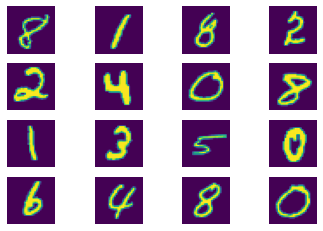

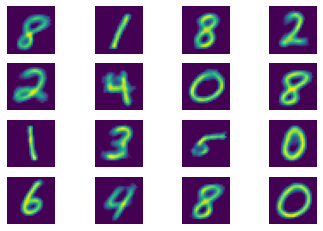

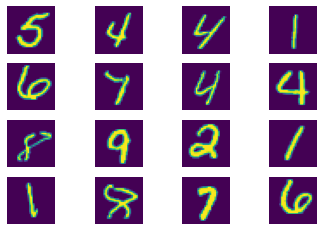

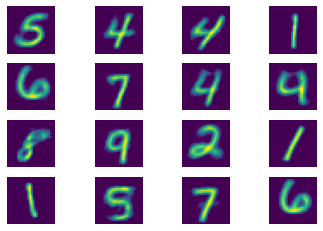

MSE:0.027717871985469874, L1 error:0.06916580158166397


In [ ]:
# Training latent dimension = 4 
if __name__ == '__main__':
    train_network = Network(latent_dims=4)
    train_network.train()
    train_network.val()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/FashionMNIST/raw

Encoder Hidden:  [784, 256, 128, 64]
Decoder Hidden:  [64, 128, 256, 784]
Epoch [0]/[50], MSE:0.03180443705829892, L1 Error: 0.09682838854915686
Epoch [1]/[50], MSE:0.017827601900588613, L1 Error: 0.07062086018086625
Epoch [2]/[50], MSE:0.015625223162581026, L1 Error: 0.06535246044301936
Epoch [3]/[50], MSE:0.014597364018493299, L1 Error: 0.06277223015273647
Epoch [4]/[50], MSE:0.013887255460524826, L1 Error: 0.06095329526982796
Epoch [5]/[50], MSE:0.013393483493425421, L1 Error: 0.059701182218536875
Epoch [6]/[50], MSE:0.013043169892346338, L1 Error: 0.05878180878489351
Epoch [7]/[50], MSE:0.012831594013751125, L1 Error: 0.0581915487347443
Epoch [8]/[50], MSE:0.012598691145385534, L1 Error: 0.057580243418412634
Epoch [9]/[50], MSE:0.012430651911525424, L1 Error: 0.057119157395883205
Epoch [10]/[50], MSE:0.01227940861811601, L1 Error: 0.056724271177450394
Epoch [11]/[50], MSE:0.01212622098954

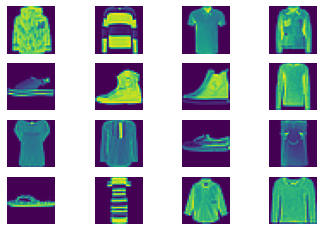

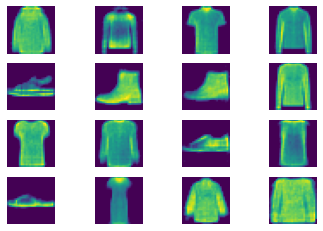

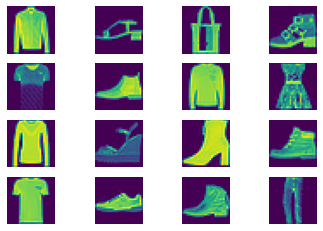

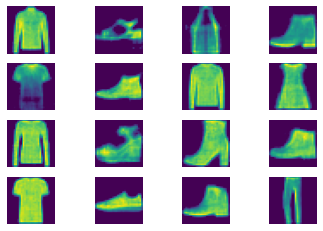

MSE:0.011373497665119477, L1 error:0.054248763916966244


In [ ]:
# Training fashion MNIST latent dimension = 64 
if __name__ == '__main__':
    train_network = Network()
    train_network.train_fashion()
    train_network.val_fashion()

Encoder Hidden:  [784, 256, 128, 32]
Decoder Hidden:  [32, 128, 256, 784]
Epoch [0]/[50], MSE:0.03223778151985548, L1 Error: 0.09784088663065064
Epoch [1]/[50], MSE:0.018263159872389526, L1 Error: 0.0717955748714594
Epoch [2]/[50], MSE:0.01643157079458046, L1 Error: 0.06744131424813159
Epoch [3]/[50], MSE:0.015226422021863237, L1 Error: 0.06440993425065578
Epoch [4]/[50], MSE:0.014435816399172633, L1 Error: 0.062315118354978785
Epoch [5]/[50], MSE:0.014015373136756768, L1 Error: 0.06123746670345232
Epoch [6]/[50], MSE:0.013703692089189779, L1 Error: 0.06041355351962173
Epoch [7]/[50], MSE:0.013481331890768977, L1 Error: 0.059868050184550124
Epoch [8]/[50], MSE:0.013287953369462566, L1 Error: 0.059330384045234996
Epoch [9]/[50], MSE:0.013077646859681975, L1 Error: 0.058835782273697367
Epoch [10]/[50], MSE:0.012952123338251256, L1 Error: 0.05850404418265425
Epoch [11]/[50], MSE:0.012827834316202326, L1 Error: 0.058150410008086975
Epoch [12]/[50], MSE:0.012725638018934933, L1 Error: 0.057

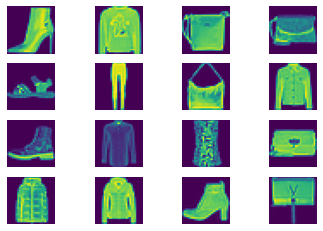

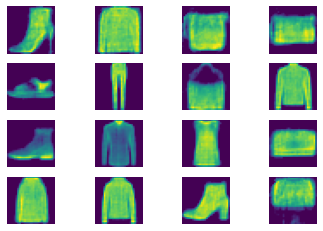

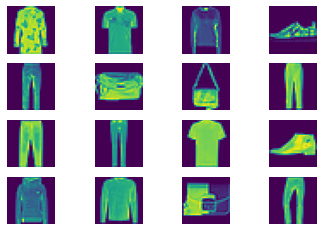

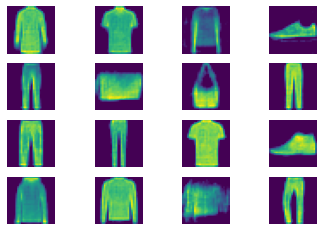

MSE:0.01135000391290165, L1 error:0.054186404611055665


In [ ]:
# Training fashion MNIST latent dimension = 32 
if __name__ == '__main__':
    train_network = Network(latent_dims=32)
    train_network.train_fashion()
    train_network.val_fashion()

Encoder Hidden:  [784, 256, 128, 4]
Decoder Hidden:  [4, 128, 256, 784]
Epoch [0]/[50], MSE:0.042022544944314975, L1 Error: 0.1190787007119765
Epoch [1]/[50], MSE:0.031338505609917154, L1 Error: 0.10053454619397985
Epoch [2]/[50], MSE:0.030091936798446208, L1 Error: 0.09770067690562541
Epoch [3]/[50], MSE:0.02950244106893033, L1 Error: 0.09635653921672349
Epoch [4]/[50], MSE:0.029040132576685196, L1 Error: 0.09545040768327683
Epoch [5]/[50], MSE:0.028737727725598065, L1 Error: 0.09480175325843797
Epoch [6]/[50], MSE:0.028459298576495692, L1 Error: 0.09423837025939083
Epoch [7]/[50], MSE:0.02827980784796727, L1 Error: 0.09389040230305243
Epoch [8]/[50], MSE:0.02809222585649857, L1 Error: 0.09348040298343087
Epoch [9]/[50], MSE:0.02801407492951179, L1 Error: 0.09328754819539975
Epoch [10]/[50], MSE:0.0278889853109704, L1 Error: 0.09302645091567757
Epoch [11]/[50], MSE:0.027708837575614133, L1 Error: 0.09252475330103169
Epoch [12]/[50], MSE:0.027643053447519574, L1 Error: 0.09236878173360

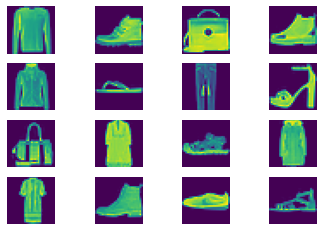

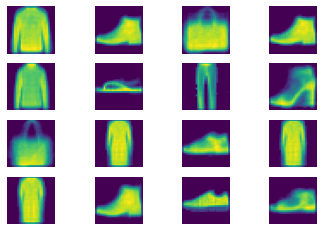

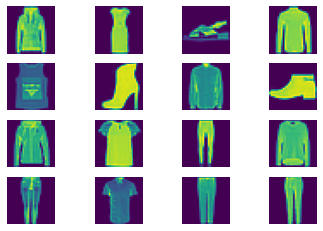

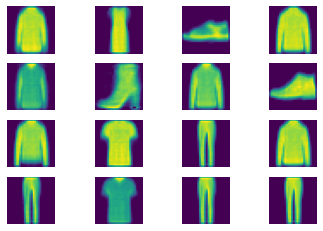

MSE:0.026758753646833774, L1 error:0.09022535340717205


In [ ]:
# Training fashion MNIST latent dimension = 4 
if __name__ == '__main__':
    train_network = Network(latent_dims=4)
    train_network.train_fashion()
    train_network.val_fashion()